In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta

from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
# df_summaries = pd.read_csv("data/articles_summary_cleaned.csv", parse_dates=["date"])
# df_summaries

In [3]:
# df_articles = pd.read_csv("data/all_africa_southsudan.csv")
# df_articles

In [4]:
# print(df_articles.date.unique().shape)

In [5]:
df_tabular = pd.read_csv("data/food_crises_cleaned.csv")

In [6]:
df_tabular.district.unique().shape

(78,)

In [7]:
# drop empty ipc rows
# df_tabular = df_tabular[~df_tabular.ipc.isna()]

In [8]:
# impute next available value backwards
df_tabular.fillna(method='bfill', axis='index', inplace=True)

In [9]:
df_tabular.year_month = df_tabular.year_month.apply(lambda x : x[:4] + '-' + x[5:])
df_tabular = df_tabular.set_index('date')
df_tabular.index = pd.to_datetime(df_tabular.index)
df_tabular['timestamp']=df_tabular.index

In [10]:
df_tabular.columns

Index(['country', 'district_code', 'district', 'centx', 'centy', 'year_month',
       'year', 'month', 'ipc', 'ha', 'ndvi_mean', 'ndvi_anom', 'rain_mean',
       'rain_anom', 'et_mean', 'et_anom', 'count_violence', 'sum_fatalities',
       'food_price_idx', 'area', 'cropland_pct', 'pop', 'ruggedness_mean',
       'pasture_pct', 'timestamp'],
      dtype='object')

In [11]:
df_model = df_tabular[['district', 'ipc', 'ha', 'ndvi_mean', 'ndvi_anom', 'rain_mean',
       'rain_anom', 'et_mean', 'et_anom', 'count_violence', 'sum_fatalities',
       'food_price_idx', 'area', 'cropland_pct', 'pop', 'ruggedness_mean',
       'pasture_pct', 'timestamp']]

In [12]:
train = df_model.loc[(df_model.index >= '2007-01-01') & (df_model.index < '2019-03-01')]
# val = df_model.loc[(df_model.index >= '2019-03-01') & (df_model.index < '2019-09-01')]
test = df_model.loc[df_model.index >= '2019-03-01']

In [13]:
# test.year_month

In [14]:
test.timestamp

date
2019-03-01   2019-03-01
2019-04-01   2019-04-01
2019-05-01   2019-05-01
2019-06-01   2019-06-01
2019-07-01   2019-07-01
                ...    
2019-10-01   2019-10-01
2019-11-01   2019-11-01
2019-12-01   2019-12-01
2020-01-01   2020-01-01
2020-02-01   2020-02-01
Name: timestamp, Length: 936, dtype: datetime64[ns]

In [40]:
train.index

DatetimeIndex(['2007-01-01', '2007-02-01', '2007-03-01', '2007-04-01',
               '2007-05-01', '2007-06-01', '2007-07-01', '2007-08-01',
               '2007-09-01', '2007-10-01',
               ...
               '2018-05-01', '2018-06-01', '2018-07-01', '2018-08-01',
               '2018-09-01', '2018-10-01', '2018-11-01', '2018-12-01',
               '2019-01-01', '2019-02-01'],
              dtype='datetime64[ns]', name='timestamp', length=11388, freq=None)

In [41]:
test.index

DatetimeIndex(['2019-03-01', '2019-04-01', '2019-05-01', '2019-06-01',
               '2019-07-01', '2019-08-01', '2019-09-01', '2019-10-01',
               '2019-11-01', '2019-12-01',
               ...
               '2019-05-01', '2019-06-01', '2019-07-01', '2019-08-01',
               '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01',
               '2020-01-01', '2020-02-01'],
              dtype='datetime64[ns]', name='date', length=936, freq=None)

# DeepAR

In [17]:
# pip install gluonts

In [18]:
from gluonts.dataset.pandas import PandasDataset

train_ds = PandasDataset.from_long_dataframe(train, target='ipc', item_id='district', 
                                       timestamp='timestamp', freq='M')

C:\Users\Goshko\anaconda3\envs\dc3\lib\site-packages\gluonts\json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [19]:
# pip install torch

In [20]:
# pip install pytorch_lightning

In [21]:
train_ds

PandasDataset<size=78, freq=M, num_feat_dynamic_real=0, num_past_feat_dynamic_real=0, num_feat_static_real=0, num_feat_static_cat=0, static_cardinalities=[]>

In [28]:
from gluonts.torch.model.deepar import DeepAREstimator

estimator = DeepAREstimator(freq='M', prediction_length=6, num_layers=3, lr=0.002, context_length=12,
                            trainer_kwargs={'max_epochs':4})

predictor = estimator.train(train_ds, num_workers=4)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\Goshko\anaconda3\envs\dc3\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:71: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(

  | Name  | Type        | Params | In sizes | Out sizes  
---------------------------------------------------------------
0 | model | DeepARModel | 36.4 K | ?        | [1, 100, 6]
---------------------------------------------------------------
36.4 K    Trainable params
0         Non-trainable params
36.4 K    Total params
0.146     Total estimated model params size (MB)


Epoch 0: : 50it [00:02, 19.89it/s, v_num=22, train_loss=1.130]

Epoch 0, global step 50: 'train_loss' reached 1.12520 (best 1.12520), saving model to 'C:\\Users\\Goshko\\Desktop\\DC3\\JBG060-DC3-23-24-public-main\\lightning_logs\\version_22\\checkpoints\\epoch=0-step=50.ckpt' as top 1


Epoch 1: : 50it [00:03, 13.77it/s, v_num=22, train_loss=0.459]

Epoch 1, global step 100: 'train_loss' reached 0.45919 (best 0.45919), saving model to 'C:\\Users\\Goshko\\Desktop\\DC3\\JBG060-DC3-23-24-public-main\\lightning_logs\\version_22\\checkpoints\\epoch=1-step=100.ckpt' as top 1


Epoch 2: : 50it [00:03, 14.42it/s, v_num=22, train_loss=0.416]

Epoch 2, global step 150: 'train_loss' reached 0.41578 (best 0.41578), saving model to 'C:\\Users\\Goshko\\Desktop\\DC3\\JBG060-DC3-23-24-public-main\\lightning_logs\\version_22\\checkpoints\\epoch=2-step=150.ckpt' as top 1


Epoch 3: : 50it [00:03, 15.83it/s, v_num=22, train_loss=0.458]

Epoch 3, global step 200: 'train_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: : 50it [00:03, 15.73it/s, v_num=22, train_loss=0.458]


In [29]:
pred = list(predictor.predict(train_ds))
all_preds = list()

for district in pred:
    district_name = district.item_id
    p = district.samples.mean(axis=0)
    # make 80% confidence interval
    p10 = np.percentile(district.samples, 10, axis=0)
    p90 = np.percentile(district.samples, 90, axis=0)
    dates = pd.date_range(start=district.start_date.to_timestamp(), periods=len(p), freq='M')
    dates2 = []
    for month in dates:
        day_num = month.strftime("%d")
        month_reset = month - timedelta(days=int(day_num) - 1)
        dates2.append(month_reset)
    district_pred = pd.DataFrame({'timestamp': dates2, 'district': district_name, 'pred': p, 'p10': p10, 'p90': p90})
    all_preds += [district_pred]

all_preds = pd.concat(all_preds, ignore_index=True)

# all_preds['date'] = all_preds.timestamp
# all_preds = all_preds.set_index('date')
# all_preds.index = pd.to_datetime(all_preds.index)
# all_preds.timestamp=all_preds.index

all_preds = all_preds.merge(test, on=['timestamp', 'district'], how='left')

In [30]:
all_preds

,timestamp,district,pred,p10,p90,ipc,ha,ndvi_mean,ndvi_anom,rain_mean,...,et_mean,et_anom,count_violence,sum_fatalities,food_price_idx,area,cropland_pct,pop,ruggedness_mean,pasture_pct
0,2019-03-01,Abiemnhom,2.962923,2.214625,3.649948,3.0,0.0,0.276236,105.41210,0.905209,...,0.002087,-0.101534,3,5,56.86615,2408.233,1.742261,233166.0,11004.64,91.48276
1,2019-04-01,Abiemnhom,2.919687,2.446548,3.530141,3.0,0.0,0.301412,105.43540,4.200479,...,0.094115,-0.578187,1,2,60.13975,2408.233,1.742261,233166.0,11004.64,91.48276
2,2019-05-01,Abiemnhom,3.035927,2.300577,3.660901,3.0,0.0,0.369932,93.22445,16.593870,...,2.348514,-1.312987,1,2,63.56867,2408.233,1.742261,233166.0,11004.64,91.48276
3,2019-06-01,Abiemnhom,3.011227,2.331328,3.567328,3.0,0.0,0.653733,107.51550,29.909640,...,19.956610,6.503822,2,1,67.31876,2408.233,1.742261,233166.0,11004.64,91.48276
4,2019-07-01,Abiemnhom,3.000909,2.288413,3.589499,3.0,0.0,0.746115,103.04760,27.005520,...,34.856580,8.504764,0,0,69.03657,2408.233,1.742261,233166.0,11004.64,91.48276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,2019-04-01,Yirol West,3.278438,2.618298,4.077453,4.0,0.0,0.333928,97.20854,8.000770,...,5.504908,0.301214,1,1,67.30182,4879.717,0.462767,154856.0,25073.43,87.71930
464,2019-05-01,Yirol West,3.369810,2.832177,3.928021,4.0,0.0,0.473855,88.21682,21.244750,...,14.344340,0.069222,1,0,73.10890,4879.717,0.462767,154856.0,25073.43,87.71930
465,2019-06-01,Yirol West,3.452632,2.788824,4.040999,4.0,0.0,0.663466,96.93623,32.142000,...,25.769410,2.144067,0,0,79.46993,4879.717,0.462767,154856.0,25073.43,87.71930
466,2019-07-01,Yirol West,3.285178,2.659244,3.997727,3.0,1.0,0.755503,103.20960,21.690270,...,34.328130,4.633834,0,0,81.82270,4879.717,0.462767,154856.0,25073.43,87.71930


In [31]:
def reg_evaluation(y_test, y_pred, district: str):    
    print(f'Results for {district}:')
    print('Mean Absolute Error:', round(mean_absolute_error(y_test, y_pred),2))
    print('Root Mean Squared Error:', round(np.sqrt(mean_squared_error(y_test, y_pred)),2))
    print('Weighted mean absolute percentage error:', 
          round(np.abs(y_test - y_pred).sum() / np.abs(y_test).sum(),2))
    print('\n')

# do clf eval after the rounding!!!

In [32]:
reg_evaluation(all_preds['ipc'], all_preds['pred'], 'all districts')

Results for all districts:
Mean Absolute Error: 0.43
Root Mean Squared Error: 0.56
Weighted mean absolute percentage error: 0.14




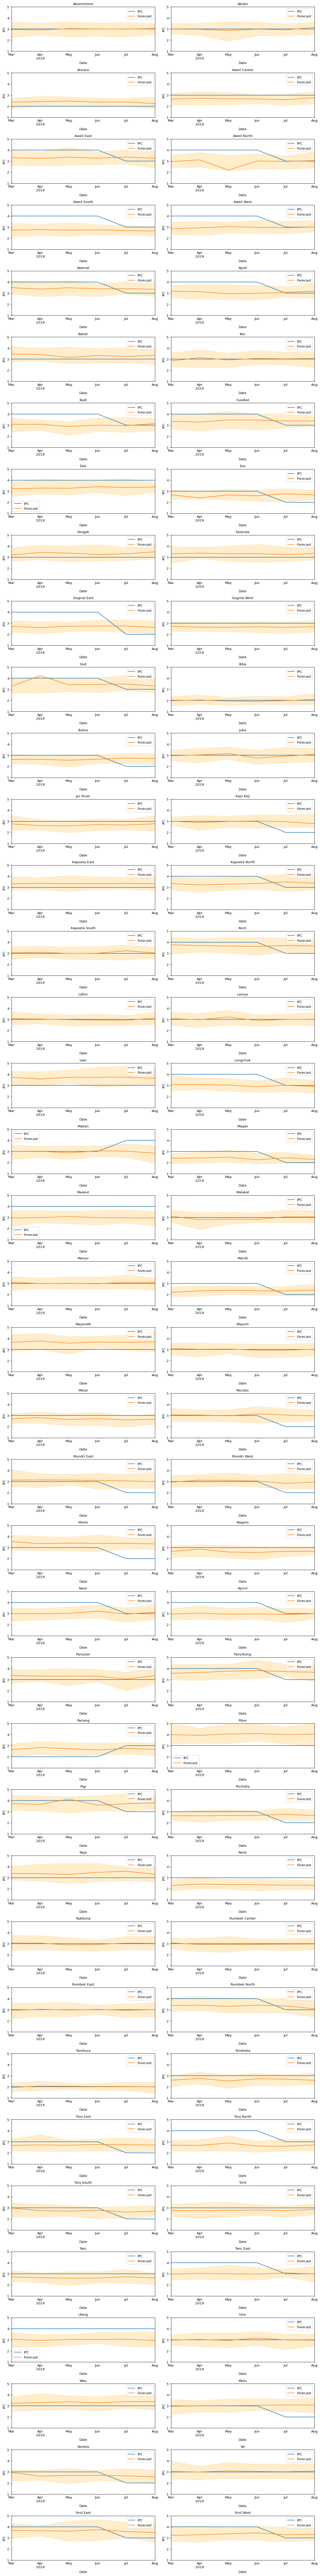

In [39]:
fig, ax = plt.subplots(39,2, figsize=(1280/96, 1280/12), dpi=96)
ax = ax.flatten()

for ax_, ward in enumerate(all_preds['district'].unique()):
    p_ = all_preds.loc[all_preds['district'] == ward]
    p_.plot(x='timestamp', y='ipc', ax=ax[ax_], label='IPC')
    p_.plot(x='timestamp', y='pred', ax=ax[ax_], label='Forecast')
    ax[ax_].fill_between(p_['timestamp'].values, p_['p10'], p_['p90'], alpha=0.2, color='orange')
    ax[ax_].set_title(ward, fontsize=10)
    ax[ax_].legend(fontsize=10)
    ax[ax_].set_xlabel('Date', fontsize=10)
    ax[ax_].set_ylabel('IPC', fontsize=10)
    ax[ax_].tick_params(axis='both', which='major', labelsize=10)
    ax[ax_].tick_params(axis='both', which='minor', labelsize=10)
    ax[ax_].set_ylim(1,5)
    
fig.tight_layout()